# Chapter 7 
 Industrial Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (2023) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored. 
"Errors" will stop execution and need to be fixed in order to get results. 

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Computer Experiments

In [2]:
import random
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import mistat
from statsmodels.nonparametric.smoothers_lowess import lowess
from itertools import chain
from mistat.design import doe

## Introduction to Computer Experiments

## Designing Computer Experiments

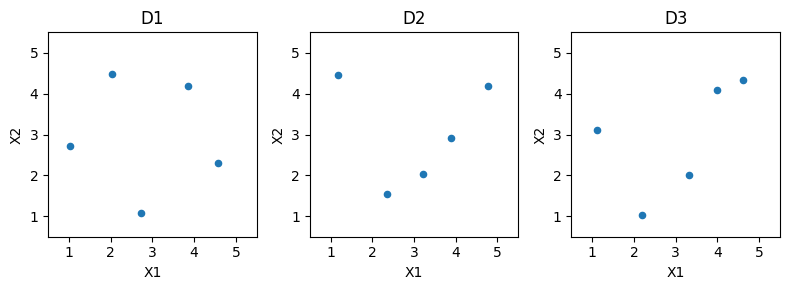

In [3]:
np.random.seed(2)

Factors = {
    'X1': [1, 5],
    'X2': [1, 5],
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))
lim = [0.5, 5.5]
for idx, ax in enumerate(axes, 1):
  if idx == 0:
    Design = doe.space_filling_lhs(Factors, num_samples=5)
  else:
    Design = doe.lhs(Factors, num_samples=5)

  Design.plot.scatter(x='X1', y='X2', ax=ax)
  ax.set_xlim(lim)
  ax.set_ylim(lim)
  ax.set_title(f'D{idx}')

plt.tight_layout()
plt.show()

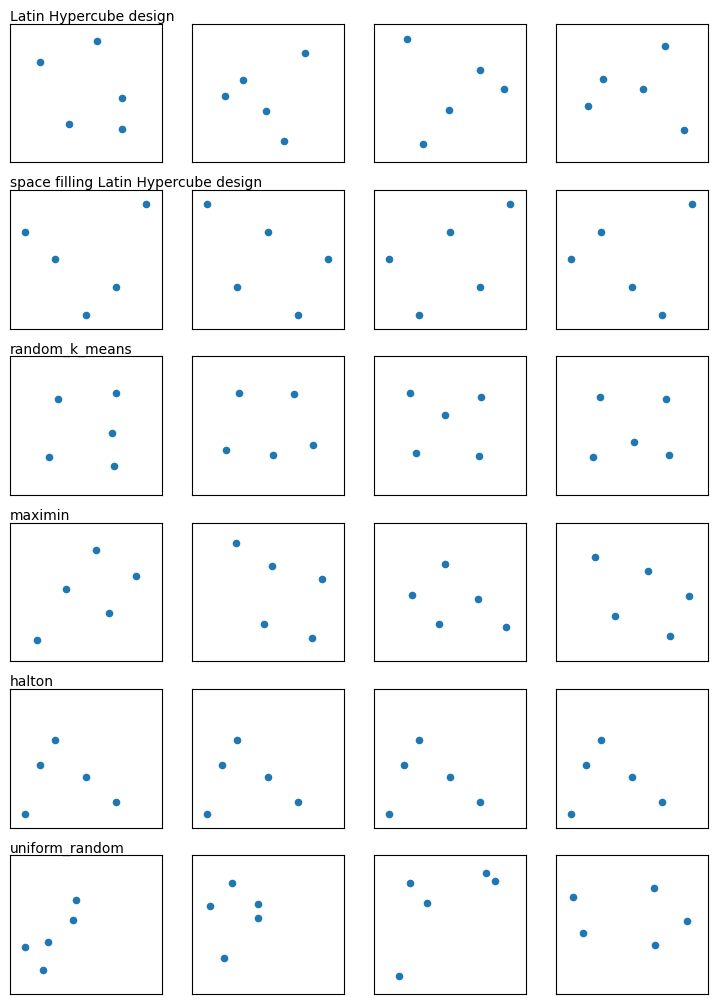

In [4]:
# various approaches to create Latin hypercube designs
# Various methods
designMethods = [
    ('Latin Hypercube design', doe.lhs),
    ('space filling Latin Hypercube design', doe.space_filling_lhs),
    ('random_k_means', doe.random_k_means),
    ('maximin', doe.maximin),
    ('halton', doe.halton),
    ('uniform_random', doe.uniform_random)
]

num_samples = 5
fig, axes = plt.subplots(nrows=len(designMethods), ncols=4, figsize=(9, 2.1 * len(designMethods)))
for nmethod, (label, builder) in enumerate(designMethods):
    np.random.seed(1)
    for idx in range(len(axes[0])):
        Design = builder(Factors, num_samples=num_samples)
        ax = axes[nmethod][idx]
        Design.plot.scatter(x='X1', y='X2', ax=ax)
        ax.set_xlim(lim)
        ax.set_ylim(lim)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
    ax = axes[nmethod][0]

for nmethod, (label, _) in enumerate(designMethods):
    ax = axes[nmethod][0]
    pos = ax.get_position()
    plt.text(pos.x0, pos.y1, label, transform=fig.transFigure, verticalalignment='bottom')

# plt.tight_layout()
plt.show()

In [5]:
from mistat.design import doe
random.seed(123)
np.random.seed(1)

Factors = {
    'm': [30, 60],
    's': [0.005, 0.02],
    'v0': [0.002, 0.01],
    'k': [1_000, 5_000],
    'p0': [90_000, 110_000],
    't': [290, 296],
    't0': [340, 360],
}
Design = doe.lhs(Factors, num_samples=14, random_state=1)

# Randomize and create replicates
nrepeat = 50
Design = Design.sample(frac=1).reset_index(drop=True)
Design = Design.loc[Design.index.repeat(nrepeat)].reset_index(drop=True)

kwargs = {c: list(Design[c]) for c in Design.columns}
simulator = mistat.PistonSimulator(**kwargs)
result = simulator.simulate()
result = mistat.simulationGroup(result, nrepeat)

mean_result = result.groupby('group').mean()

In [6]:
mean_result

,m,s,v0,k,p0,t,t0,seconds
group,,,,,,,,
1,34.344402,0.014696,0.007794,3761.084184,103592.698732,294.261969,348.211665,0.049807
2,50.173241,0.018817,0.004110,1086.380735,97082.699329,295.036118,356.212712,0.018971
3,59.891763,0.017590,0.002879,2263.173607,108090.630711,291.942785,350.076232,0.014694
4,54.316641,0.019411,0.002000,2433.796651,100379.352371,290.516194,355.610727,0.009786
5,38.935351,0.012521,0.005488,4704.240013,98214.491878,293.606024,342.683025,0.043030
6,56.292703,0.008550,0.008701,2107.539758,104853.824053,295.958591,348.982536,0.103250
7,38.503418,0.012274,0.006388,2842.255293,99869.422147,293.210674,353.695079,0.049174
8,32.883344,0.015862,0.004342,4395.230312,106605.246010,295.409298,344.341507,0.022921
9,48.373109,0.007861,0.005334,4087.826082,101574.763470,292.697263,340.266086,0.075560


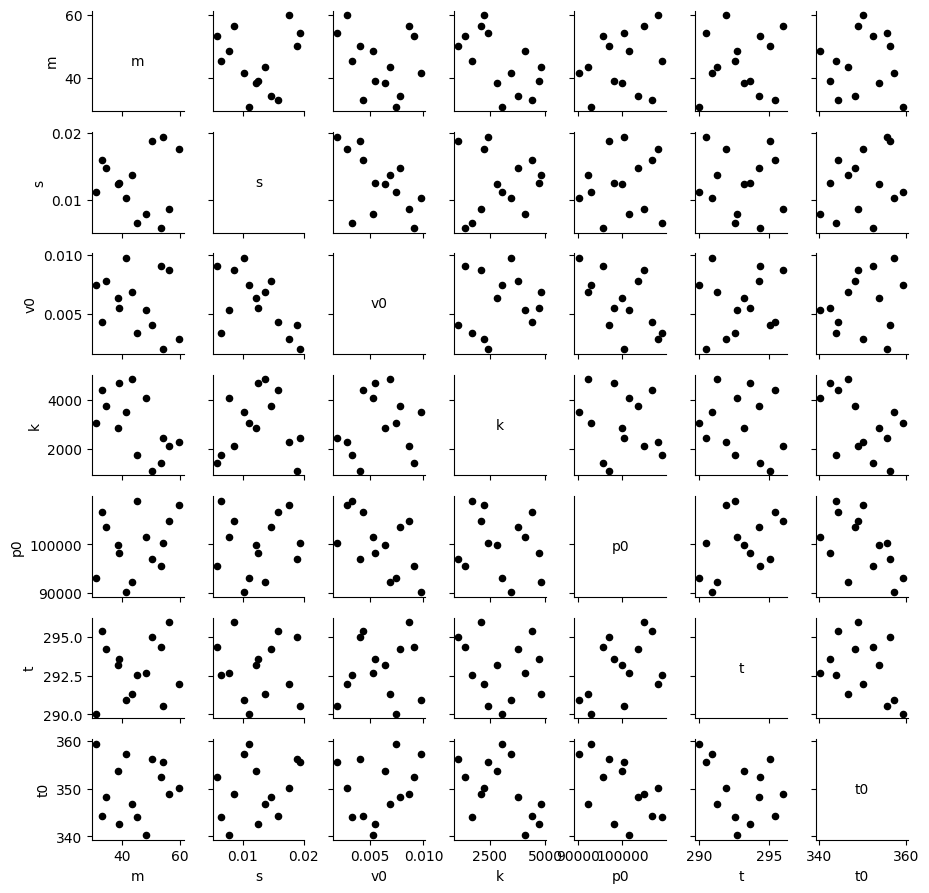

In [7]:
np.random.seed(1)
Design = doe.lhs(Factors, num_samples=14, random_state=1)

def panelPlot(x, y, **kwargs):
    plt.scatter(x, y, **kwargs,
                facecolors='black', edgecolor='black', s=20)
    dx = 0.05*(max(x) - min(x))
    plt.xlim(min(x)-dx, max(x) + dx)
    dy = 0.05*(max(y) - min(y))
    plt.ylim(min(y)-dy, max(y) + dy)

g = sns.PairGrid(Design, height=1.3)
g = g.map_offdiag(panelPlot)
for idx, column in enumerate(Factors):
    ax = g.axes[idx][idx]
    ax.text(0.5, 0.5, column, transform=ax.transAxes,
            verticalalignment='center', horizontalalignment='center')

## Analyzing Computer Experiments

In [8]:
import pylibkriging as lk
outcome = 'seconds'
predictors = ['m', 's', 'v0', 'k', 'p0', 't', 't0']

model = lk.Kriging(mean_result[outcome], mean_result[predictors], 'gauss')

In [9]:
def looValidation(data):
    jackknife  = []
    for i, row in data.iterrows():
        subset = data.drop(i)
        model = lk.Kriging(subset[outcome], subset[predictors], 'gauss')
        y_pred = model.predict([row[predictors]], True, False, False)
        jackknife.append({
            'actual': row[outcome],
            'predicted': y_pred[0],
        })
    return pd.DataFrame(jackknife)
validation = looValidation(mean_result)

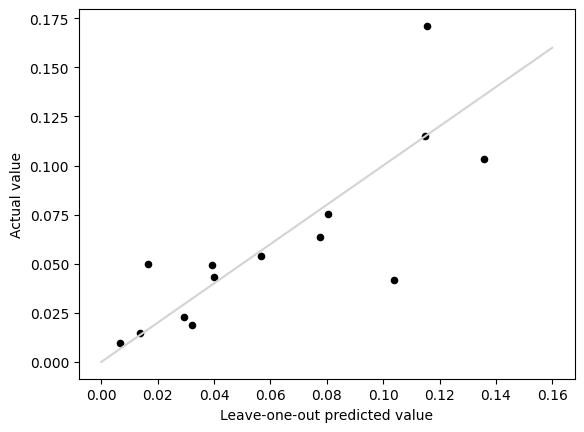

In [10]:
ax = validation.plot.scatter(x='predicted', y='actual', color='black')
ax.plot([0, 0.16], [0, 0.16], color='lightgrey')
ax.set_xlabel('Leave-one-out predicted value')
ax.set_ylabel('Actual value')
plt.show()

In [11]:
from sklearn import metrics
MAE = metrics.mean_absolute_error(validation['actual'], validation['predicted'])
R2 = metrics.r2_score(validation['actual'], validation['predicted'])
print(f'MAE = {MAE:.4f}')
print(f'r2 {R2:.3f}', )

MAE = 0.0173
r2 0.628


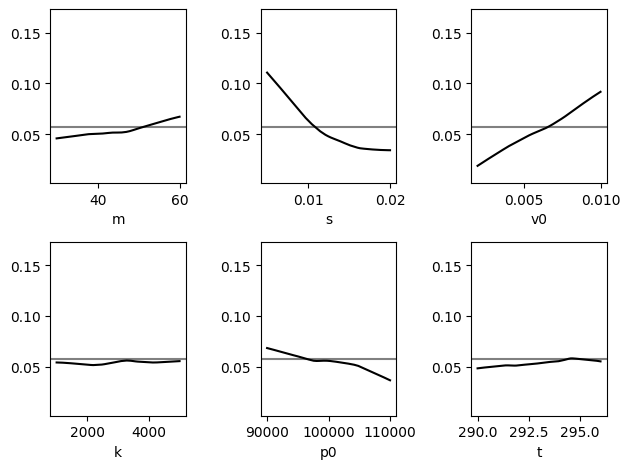

In [12]:
random.seed(1)

# create a large Latin hypercube design
Design = doe.lhs(Factors, num_samples=500, random_state=1)

# for each row in the design, predict the cycle time using the kriging model
predictions = []
for _, row in Design.iterrows():
    predictions.append(model.predict([row[predictors]], True, False, False)[0])
Design['seconds'] = predictions

# determine and plot the marginal distribution using lowess regression
fig, axes = plt.subplots(ncols=3, nrows=2)
ylim = (min(Design['seconds']),max(Design['seconds']))
for ax, column in zip(chain.from_iterable(axes), predictors):
    fit = lowess(Design['seconds'], Design[column],
                 frac=0.5, it=1, return_sorted=True)
    fit = pd.DataFrame(fit, columns=['x', 'y'])
    ax.axhline(Design['seconds'].mean(), color='grey')
    ax.plot(fit['x'], fit['y'], color='black')
    ax.set_ylim(ylim)
    ax.set_xlabel(column)
plt.tight_layout()

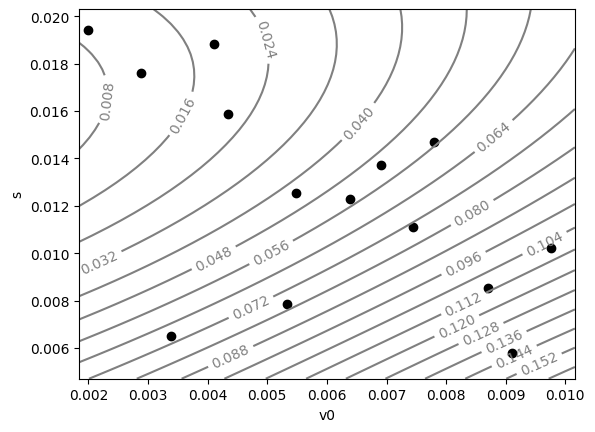

In [13]:
def plotSurface(model, data, f1, f2, ncontours=20):
    def linspace(limits):
        lmin, lmax = limits
        padding = 0.02 * (lmax - lmin)
        return np.linspace(lmin-padding, lmax+padding)
    x1 = linspace(Factors[f1])
    x2 = linspace(Factors[f2])
    X1, X2 = np.meshgrid(x1, x2)

    grid = {f1: X1.ravel(), f2: X2.ravel()}
    for f in predictors:
        if f in (f1, f2):
            continue
        grid[f] = np.mean(Factors[f])
    df = pd.DataFrame(grid)
    responses = np.array([
      model.predict([v.values], True, False, False)[0]
      for _, v in df[predictors].iterrows()])

    # display in factor co-ordinates
    svalues = x1
    kvalues = x2
    CS = plt.contour(svalues, kvalues,
                responses.reshape(len(x2), len(x1)),
                ncontours, colors='gray')
    ax = plt.gca()
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.scatter(data['v0'], data['s'], color='black')
    return ax

ax = plotSurface(model, mean_result, 'v0', 's')
plt.show()

## Stochastic Emulators

## Integrating Physical and Computer Experiments

## Simulation of Random Variables

### Basic Procedures

### Generating Random Vectors

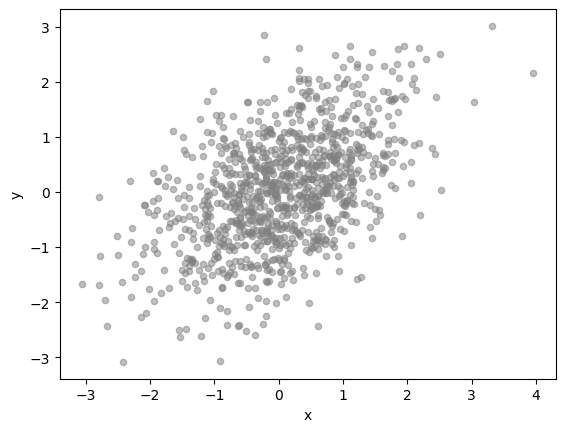

In [14]:
np.random.seed(1)

def standardBivariateNorm(rho, Ns):
  X = stats.norm.rvs(size=Ns)
  Y = rho*X + np.sqrt(1-rho**2)*stats.norm.rvs(size=Ns)
  return pd.DataFrame({'x': X, 'y': Y})

standardBivariateNorm(0.5, 1000).plot.scatter('x', 'y', alpha=0.5, color='gray')
plt.show()

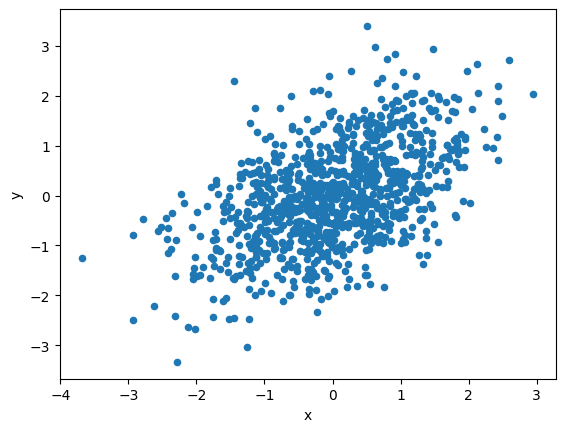

In [15]:
rv = stats.multivariate_normal.rvs(mean=(0, 0), cov=[[1, 0.5], [0.5, 1]],
                                   size=1000)
pd.DataFrame(rv, columns=('x', 'y')).plot.scatter('x', 'y')
plt.show()

### Approximating Integrals

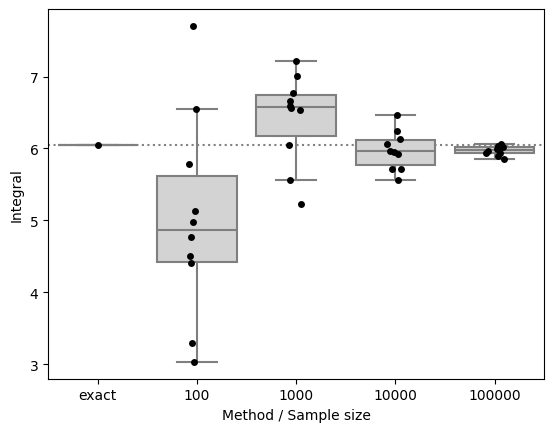

Integral          
            mean    median
Method                    
100     5.014902  4.872166
1000    6.418258  6.576374
10000   5.973676  5.961514
100000  5.968958  5.976106
exact   6.049647  6.049647

In [16]:
np.random.seed(2)

rho = 0.8
exact = np.exp(1 + rho)
integrals = [{'Method': 'exact', 'Integral': exact}]

# simulate
for Ns in (100, 1000, 10_000, 100_000):
  for _ in range(10):
    rv = standardBivariateNorm(rho, Ns)
    integrals.append({
      'Method': str(Ns),
      'Integral': np.mean(np.exp(rv['x'] + rv['y'])),
    })
df = pd.DataFrame(integrals)
ax = sns.boxplot(x=df['Method'], y=df['Integral'], color='lightgrey', fliersize=0)
ax = sns.stripplot(x=df['Method'], y=df['Integral'], color='black', ax=ax)
ax.axhline(exact, linestyle=':', color='grey', zorder=0)
ax.set_xlabel('Method / Sample size')
plt.show()

pd.DataFrame(integrals).groupby('Method').aggregate(['mean', 'median'])

## Chapter Highlights

## Exercises